# Dask tutorial SciPyConf 2020
- Tutorial: https://github.com/dask/dask-tutorial
- Video: https://www.youtube.com/watch?v=EybGGLbLipI&list=PLYx7XA2nY5Gde-6QO98KUJ9iL_WW4rgYf&index=6

In [1]:
from dask.distributed import Client

# qsub -IVX -l nodes=1:ppn=4,mem=16g,vmem=16g,walltime=03:00:00
client = Client()

In [2]:
client

Client Scheduler: tcp://127.0.0.1:42700 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


If we don't ask for a specific number of cores, I guess we can restric the number of workers like this:
```python
client = Client(n_workers=4)
```

or there is a way to adapt also the number of workers that looks pretty good: https://docs.dask.org/en/latest/setup/adaptive.html

## Basics

In [3]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [4]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 265 ms, sys: 49 ms, total: 314 ms
Wall time: 3 s


In [5]:
from dask import delayed

In [6]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.68 ms


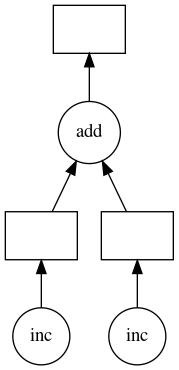

In [7]:
z.visualize()

In [8]:
%time z.compute()

CPU times: user 232 ms, sys: 46 ms, total: 278 ms
Wall time: 2.04 s


5

## Parallelize a for loop

In [9]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)
total

CPU times: user 683 ms, sys: 128 ms, total: 811 ms
Wall time: 8.01 s


44

In [14]:
%%time
# Parallel code

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)

# No computation yet
total = delayed(sum)(results)
total

CPU times: user 5 ms, sys: 2 ms, total: 7 ms
Wall time: 4.73 ms


Delayed('sum-135f698c-569e-4a18-9519-1b2efb1d89db')

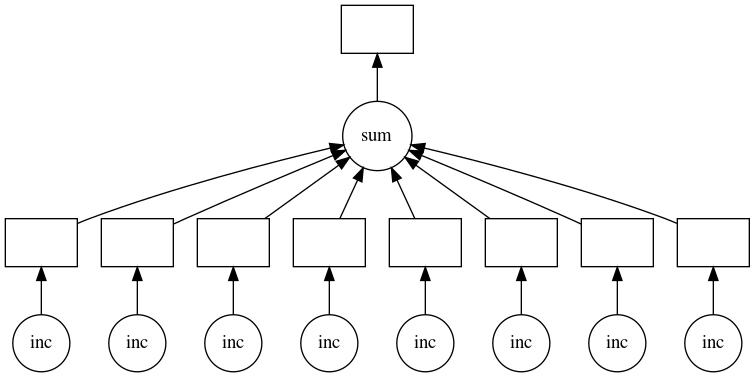

In [15]:
total.visualize()

In [16]:
# We have 4 workers here so it should be 4 times faster
# Sequential 8s -> here 2s ok

%%time
total.compute()

CPU times: user 261 ms, sys: 33 ms, total: 294 ms
Wall time: 2.06 s


44

## Xarray open_mfdataset
Let's try to open all files from `/bdd/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r2i1p1f1/Amon/tas/gr/latest/` where there is 1 file per year

In [85]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [101]:
%%time

# Sequential
ds_seq = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r2i1p1f1/Amon/tas/gr/latest/*.nc', 
        combine='by_coords', parallel=False
)

CPU times: user 14.6 s, sys: 1.02 s, total: 15.7 s
Wall time: 25.4 s


In [91]:
# We still get a dask array with one chunk per year but the opening is sequential
# ds.tas.data

In [92]:
%%time

# Parallel (not much faster, here there is only the creation of pointers, the data are not loaded!)
# It will be late when we do computation that we will see the difference!
ds_par = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r2i1p1f1/Amon/tas/gr/latest/*.nc', 
        combine='by_coords', parallel=True
)

CPU times: user 9.06 s, sys: 693 ms, total: 9.76 s
Wall time: 19.3 s


### Let's make some computation with and without chunks
The automatic chunks are from 1 years, so let's change this. Let's chunk still on the time dimension for doing a spatial avarage for example (4 workers so let's make 4 chunks).

#### With chunks

In [93]:
da = ds_par.tas.chunk(chunks={'time': ds.time.size//4, 'lat': -1, 'lon': -1})
da.chunks

((480, 480, 480, 480), (256,), (512,))

In [94]:
# Let's make weights
# New in xarray: http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"

In [95]:
da_weighted = da.weighted(weights)
da_weighted

DataArrayWeighted with weights along dimensions: lat

In [96]:
%%time

# We can direclty make the mean like this now (the will be taken into account)
# So far no data is loaded and no computation is done (until we call compute!)
weighted_mean = da_weighted.mean(dim=('lon', 'lat')).compute() - 273.15

CPU times: user 2.65 s, sys: 194 ms, total: 2.85 s
Wall time: 8.57 s


Text(0, 0.5, 'Near-Surface Air Temperature [°C]')

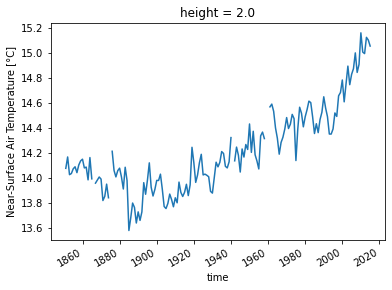

In [97]:
# The missing values are coming from missng files on CICLAD for some years
weighted_mean.resample(time='1Y').mean('time').plot()
plt.ylabel(ds_par.tas.long_name + ' [°C]')

#### Without chunks
Here we use the dataset open not in parallel (`ds_seq`), in fact we could use the parallel dataset for opening and not using chunks or oposite etc.

In [ ]:
# I don't know why it still use parallel for opening, maybe I need to reboot kernel
# But I'm closing the client here to make sure there is no parallel possible anymore
client.close()

In [106]:
da = ds_seq.tas.chunk(chunks={'time': -1, 'lat': -1, 'lon': -1})
da.chunks

((1920,), (256,), (512,))

In [107]:
da_weighted = da.weighted(weights)

In [108]:
%%time
weighted_mean = da_weighted.mean(dim=('lon', 'lat')).compute() - 273.15

CPU times: user 16.7 s, sys: 1.61 s, total: 18.3 s
Wall time: 19.7 s


## Results
- parallel Wall time: 8.57 s
- sequential Wall time: 19.7 s

A bit more than twice faster, but maybe the opening was still in parallel here.